In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
import xgboost as xgb





In [2]:
df = pd.read_csv('/content/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [7]:
df.isna().sum()

,0
date,0
store,0
item,0
sales,0


In [8]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

In [9]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


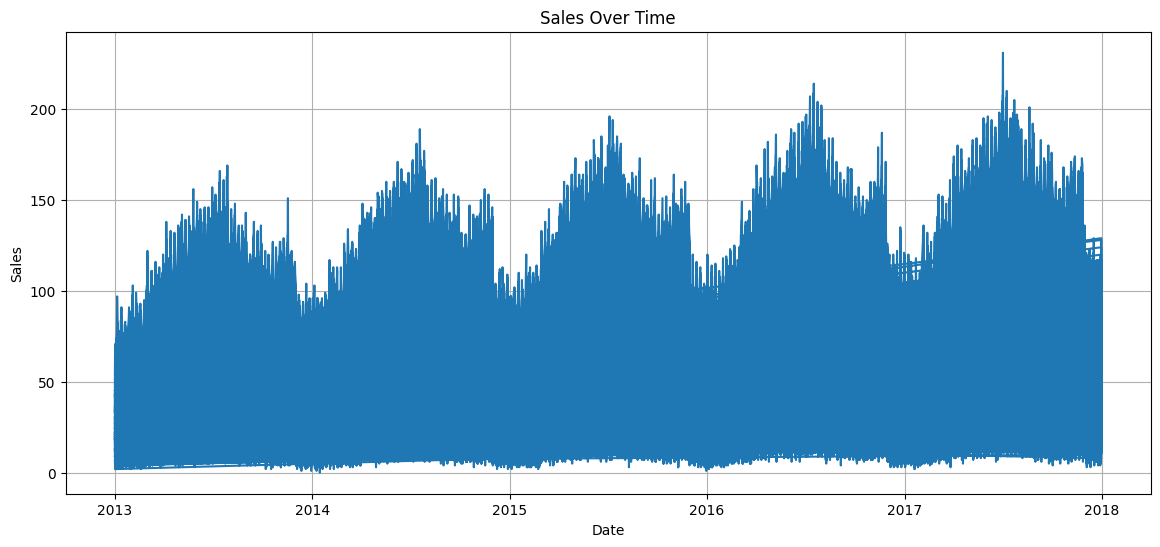

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['sales'])
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

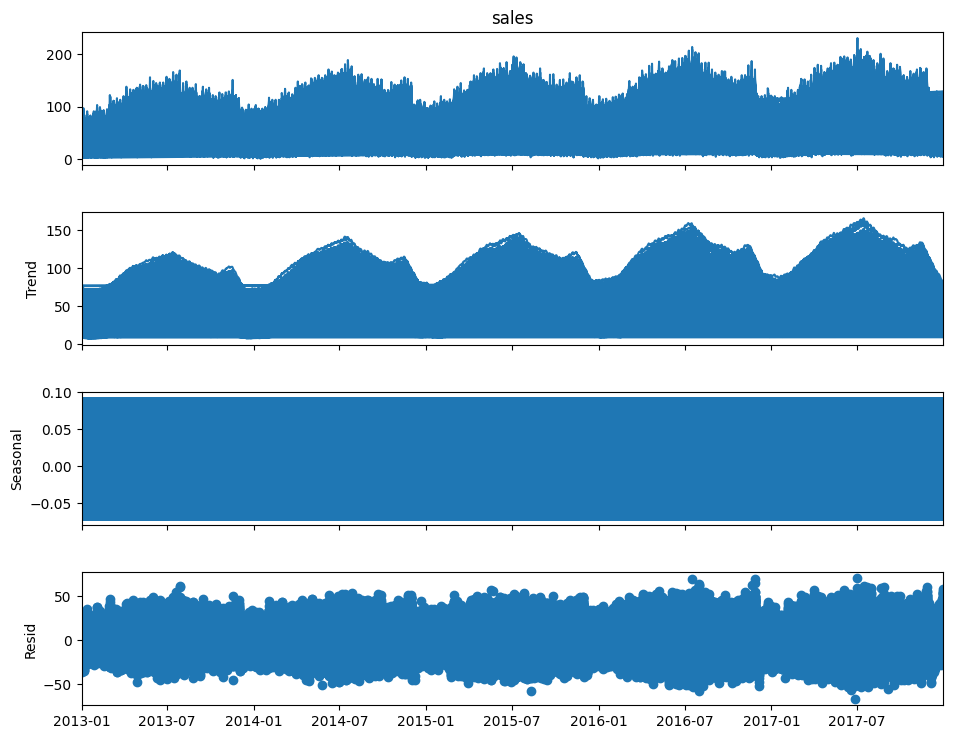

In [11]:
result = seasonal_decompose(df.set_index('date')['sales'], model='additive',period=30) #monthly

fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


In [12]:
df.set_index('date',inplace=True)

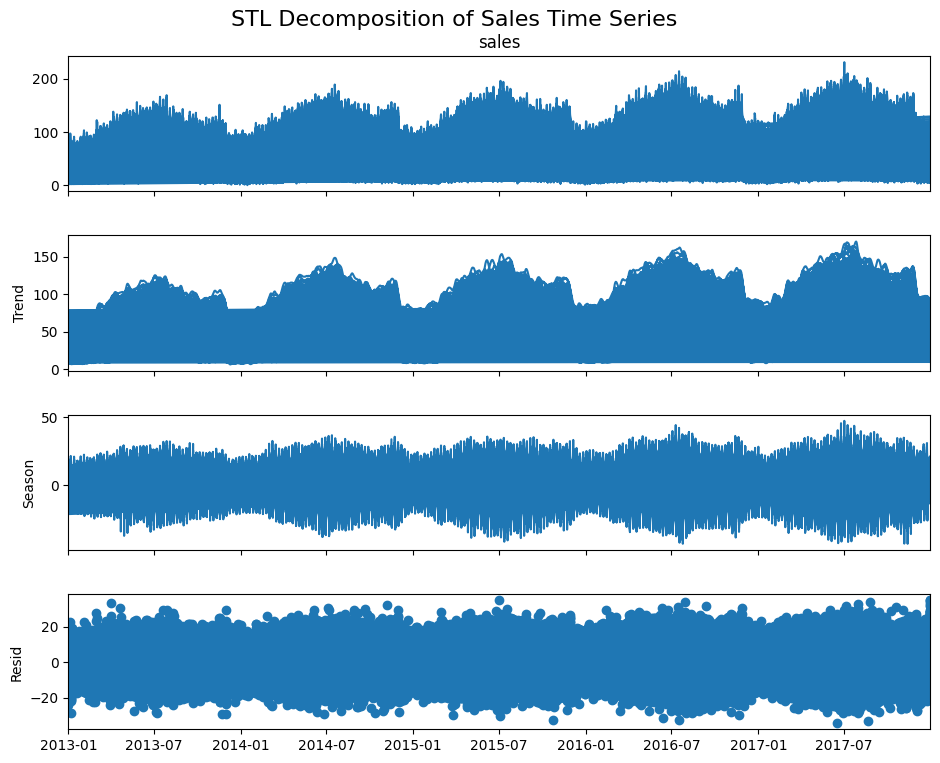

In [13]:
stl = STL(df['sales'], period=7)  # 7 for weekly
result = stl.fit()


fig = result.plot()
fig.set_size_inches(10, 8)
plt.suptitle('STL Decomposition of Sales Time Series', fontsize=16)
plt.show()

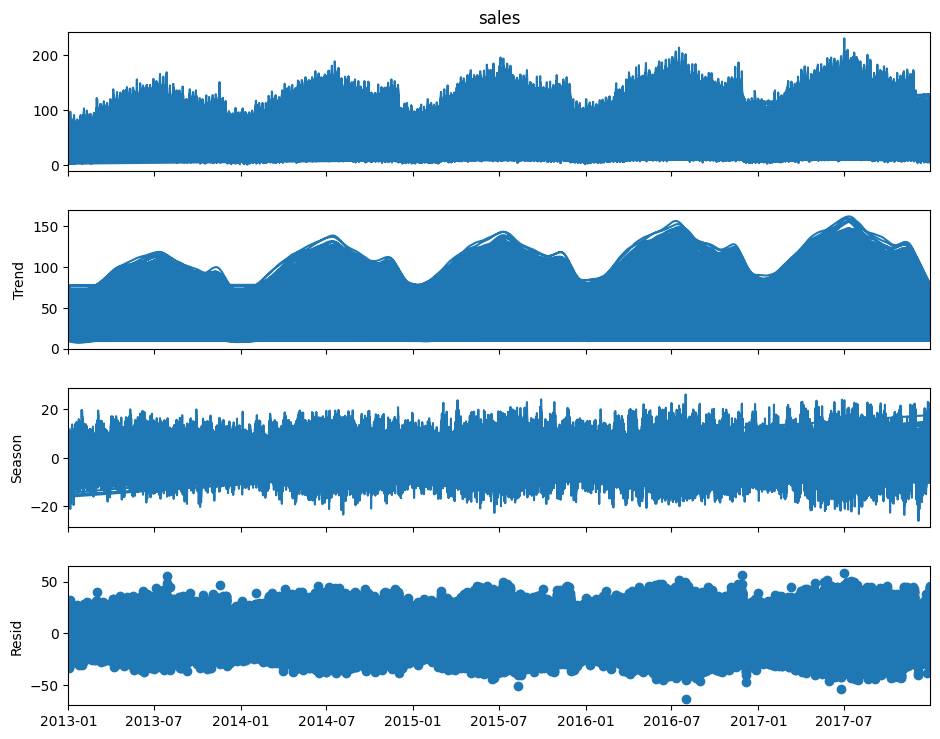

In [14]:
stl2 = STL(df['sales'], period=30)  # 30 for monthly
result2 = stl2.fit()


fig2 = result2.plot()
fig2.set_size_inches(10, 8)
plt.show()

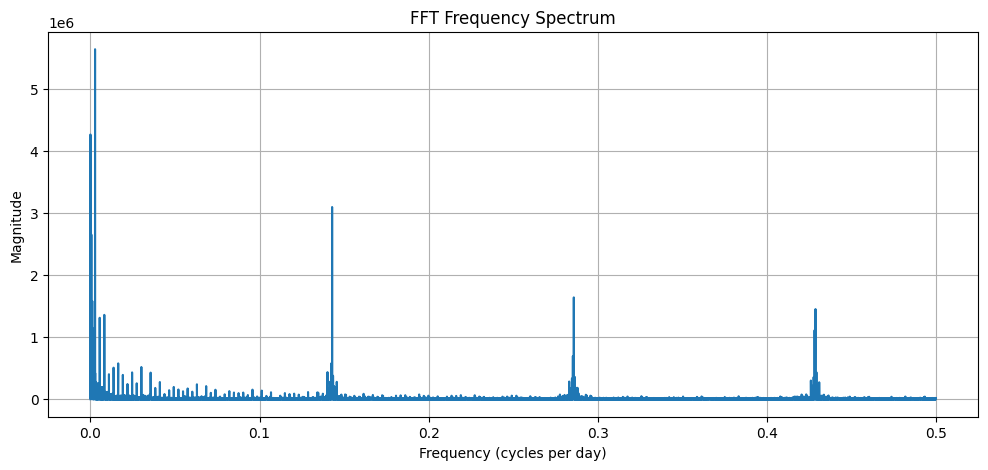

In [15]:
sales_detrend = df['sales'] - df['sales'].mean()

fft_vals = np.fft.fft(sales_detrend)
fft_freq = np.fft.fftfreq(len(sales_detrend),d=1)

positive_freqs = fft_freq[:len(fft_freq)//2]
magnitude = np.abs(fft_vals[:len(fft_vals)//2])


plt.figure(figsize=(12, 5))
plt.plot(positive_freqs, magnitude)
plt.title('FFT Frequency Spectrum')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

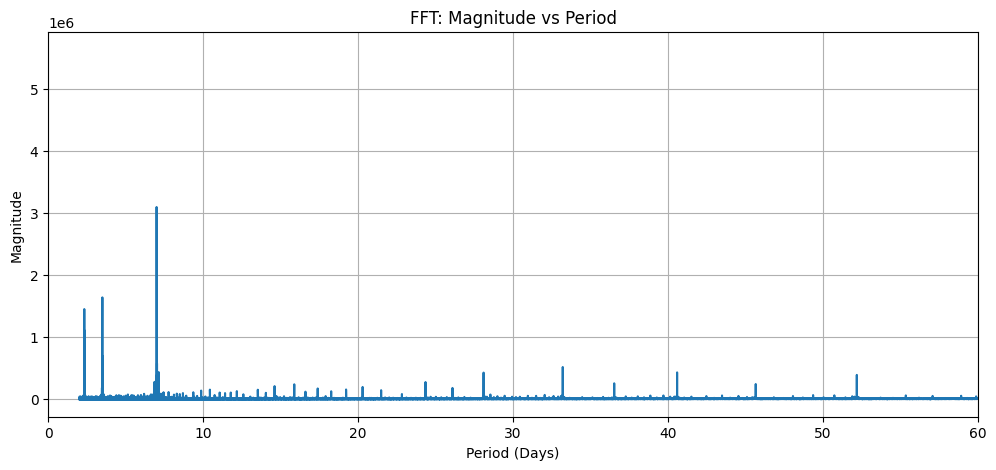

In [78]:
periods = 1 / positive_freqs

plt.figure(figsize=(12, 5))
plt.plot(periods, magnitude)
plt.title("FFT: Magnitude vs Period")
plt.xlabel("Period (Days)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(0, 60) #2-month cycles
plt.show()


In [17]:
df.reset_index(inplace=True)

## Experimenting with Prophet

In [18]:
df.drop(columns=['store','item'],axis=1,inplace=True)

In [19]:
df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [20]:
df_prophet = df.rename(columns={'date':'ds','sales':'y'})

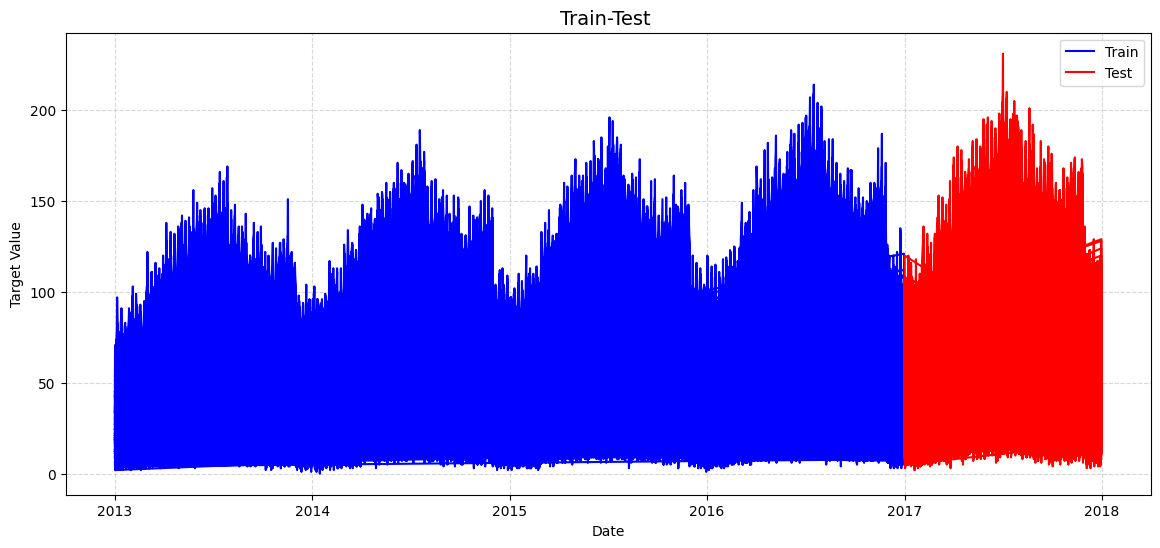

In [21]:
train_df = df_prophet[df_prophet['ds']<"2017-01-01"]
test_df = df_prophet[df_prophet['ds']>="2017-01-01"]

plt.figure(figsize=(14, 6))
plt.plot(train_df["ds"], train_df["y"], color="blue", label="Train")
plt.plot(test_df["ds"], test_df["y"], color="red", label="Test")
plt.title("Train-Test ", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [22]:
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/jrqntopz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/8_8ms8og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52102', 'data', 'file=/tmp/tmp6_s2i6xn/jrqntopz.json', 'init=/tmp/tmp6_s2i6xn/8_8ms8og.json', 'output', 'file=/tmp/tmp6_s2i6xn/prophet_model4_bgah2v/prophet_model-20250718110315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
tes_scores = model.predict(test_df)

In [24]:
tes_scores.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,58.069739,23.854982,84.977527,58.069739,58.069739,-5.755339,-5.755339,-5.755339,9.625283,9.625283,9.625283,-15.380622,-15.380622,-15.380622,0.0,0.0,0.0,52.314399
1,2017-01-01,58.069739,21.145093,82.197696,58.069739,58.069739,-5.755339,-5.755339,-5.755339,9.625283,9.625283,9.625283,-15.380622,-15.380622,-15.380622,0.0,0.0,0.0,52.314399
2,2017-01-01,58.069739,21.333651,84.718823,58.069739,58.069739,-5.755339,-5.755339,-5.755339,9.625283,9.625283,9.625283,-15.380622,-15.380622,-15.380622,0.0,0.0,0.0,52.314399
3,2017-01-01,58.069739,18.592489,83.013615,58.069739,58.069739,-5.755339,-5.755339,-5.755339,9.625283,9.625283,9.625283,-15.380622,-15.380622,-15.380622,0.0,0.0,0.0,52.314399
4,2017-01-01,58.069739,19.231189,83.474767,58.069739,58.069739,-5.755339,-5.755339,-5.755339,9.625283,9.625283,9.625283,-15.380622,-15.380622,-15.380622,0.0,0.0,0.0,52.314399


In [25]:
test_df.head()

,ds,y
1461,2017-01-01,19
1462,2017-01-02,15
1463,2017-01-03,10
1464,2017-01-04,16
1465,2017-01-05,14


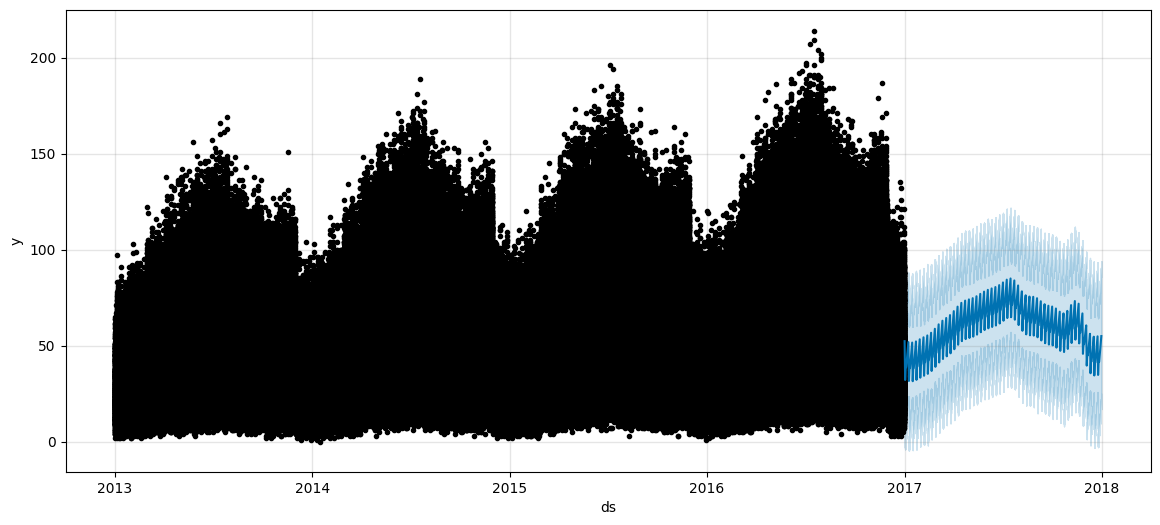

In [26]:
fig,ax = plt.subplots(figsize=(14,6))
fig = model.plot(tes_scores,ax=ax)
plt.show()

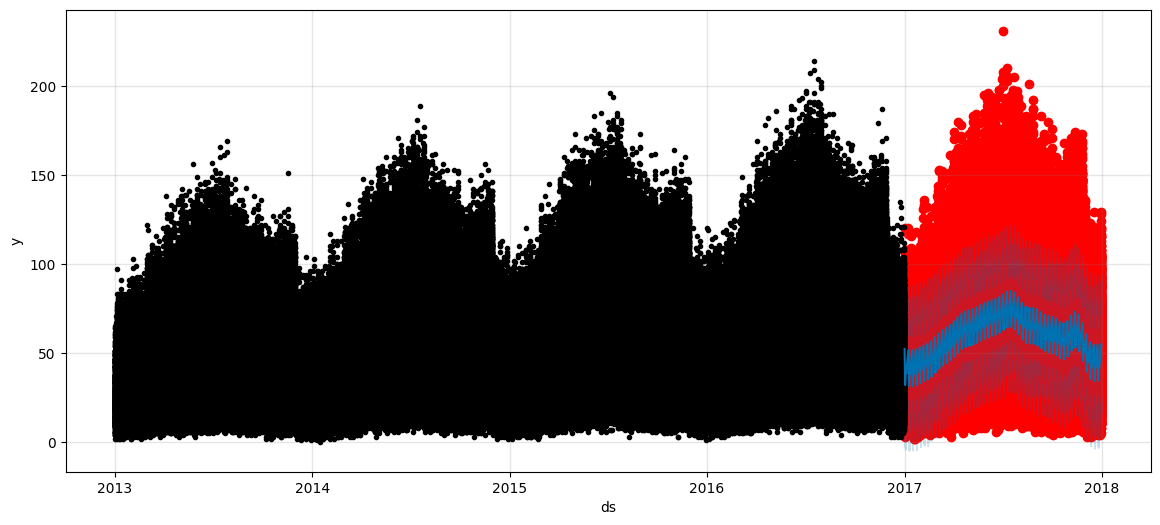

In [27]:
f,ax = plt.subplots(figsize=(14,6))
ax.scatter(test_df['ds'],test_df['y'],color = 'red')
fig = model.plot(tes_scores,ax=ax)
plt.show()


In [28]:
print(f'MSE: {mean_squared_error(test_df["y"],tes_scores["yhat"])}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_df["y"],tes_scores["yhat"]))}')
print(f'MAE: {mean_absolute_error(test_df["y"],tes_scores["yhat"])}')
print(f'R2: {r2_score(test_df["y"],tes_scores["yhat"])}')

MSE: 1047.829609437967
RMSE: 32.370196314479884
MAE: 26.29304882914871
R2: -0.052495046836700254


In [29]:
model_2 = Prophet()
model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_2.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/t4mtiszq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/_o8wtxbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1031', 'data', 'file=/tmp/tmp6_s2i6xn/t4mtiszq.json', 'init=/tmp/tmp6_s2i6xn/_o8wtxbh.json', 'output', 'file=/tmp/tmp6_s2i6xn/prophet_modelgtrcgpf2/prophet_model-20250718110740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
future = model_2.predict(test_df)
future.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,58.230261,19.703542,83.557746,58.230261,58.230261,-5.578914,-5.578914,-5.578914,0.050706,...,9.626112,9.626112,9.626112,-15.255731,-15.255731,-15.255731,0.0,0.0,0.0,52.651347
1,2017-01-01,58.230261,21.803485,83.515114,58.230261,58.230261,-5.578914,-5.578914,-5.578914,0.050706,...,9.626112,9.626112,9.626112,-15.255731,-15.255731,-15.255731,0.0,0.0,0.0,52.651347
2,2017-01-01,58.230261,22.258396,84.326490,58.230261,58.230261,-5.578914,-5.578914,-5.578914,0.050706,...,9.626112,9.626112,9.626112,-15.255731,-15.255731,-15.255731,0.0,0.0,0.0,52.651347
3,2017-01-01,58.230261,19.486598,82.982488,58.230261,58.230261,-5.578914,-5.578914,-5.578914,0.050706,...,9.626112,9.626112,9.626112,-15.255731,-15.255731,-15.255731,0.0,0.0,0.0,52.651347
4,2017-01-01,58.230261,20.581280,82.774398,58.230261,58.230261,-5.578914,-5.578914,-5.578914,0.050706,...,9.626112,9.626112,9.626112,-15.255731,-15.255731,-15.255731,0.0,0.0,0.0,52.651347


In [31]:
print(f'MSE: {mean_squared_error(test_df["y"],future["yhat"])}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_df["y"],future["yhat"]))}')
print(f'MAE: {mean_absolute_error(test_df["y"],future["yhat"])}')
print(f'R2: {r2_score(test_df["y"],future["yhat"])}')

MSE: 1047.9776944530536
RMSE: 32.372483600321026
MAE: 26.33707561958334
R2: -0.0526437911969333


In [32]:
m = Prophet(changepoint_prior_scale=0.1,
            seasonality_prior_scale=10,
            daily_seasonality=True,)
m.fit(train_df)

future_2 = m.predict(test_df)
future_2.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/nyay4zn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_s2i6xn/fex097bu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13800', 'data', 'file=/tmp/tmp6_s2i6xn/nyay4zn2.json', 'init=/tmp/tmp6_s2i6xn/fex097bu.json', 'output', 'file=/tmp/tmp6_s2i6xn/prophet_modely_z8uykt/prophet_model-20250718111250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,31.84156,19.003896,88.865817,31.84156,31.84156,20.63138,20.63138,20.63138,26.276974,...,9.626038,9.626038,9.626038,-15.271632,-15.271632,-15.271632,0.0,0.0,0.0,52.47294
1,2017-01-01,31.84156,20.585570,83.879941,31.84156,31.84156,20.63138,20.63138,20.63138,26.276974,...,9.626038,9.626038,9.626038,-15.271632,-15.271632,-15.271632,0.0,0.0,0.0,52.47294
2,2017-01-01,31.84156,21.028710,83.545438,31.84156,31.84156,20.63138,20.63138,20.63138,26.276974,...,9.626038,9.626038,9.626038,-15.271632,-15.271632,-15.271632,0.0,0.0,0.0,52.47294
3,2017-01-01,31.84156,20.920742,85.442320,31.84156,31.84156,20.63138,20.63138,20.63138,26.276974,...,9.626038,9.626038,9.626038,-15.271632,-15.271632,-15.271632,0.0,0.0,0.0,52.47294
4,2017-01-01,31.84156,20.705032,86.572656,31.84156,31.84156,20.63138,20.63138,20.63138,26.276974,...,9.626038,9.626038,9.626038,-15.271632,-15.271632,-15.271632,0.0,0.0,0.0,52.47294


In [33]:
print(f'MSE: {mean_squared_error(test_df["y"],future_2["yhat"])}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_df["y"],future_2["yhat"]))}')
print(f'MAE: {mean_absolute_error(test_df["y"],future_2["yhat"])}')
print(f'R2: {r2_score(test_df["y"],future_2["yhat"])}')

MSE: 1047.0992029851257
RMSE: 32.358912265172414
MAE: 26.29614129873751
R2: -0.051761388265813446


In [34]:
def mase(y_true, y_pred, y_train, seasonality=12):
    naive_errors = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    model_errors = np.abs(y_true - y_pred)
    return np.mean(model_errors) / np.mean(naive_errors)

In [35]:
print(f'MASE: {mase(test_df["y"],future_2["yhat"],train_df["y"])}')

MASE: inf


In [36]:
def smape(y_true,y_pred):
  denom = (abs(y_true) + abs(y_pred)) / 2
  errors = abs(y_true - y_pred) / denom
  return 100 * np.sum(errors) / len(y_true)

In [37]:
print(f'SMAPE: {smape(test_df["y"],tes_scores["yhat"])}')
print(f'SMAPE: {smape(test_df["y"],future["yhat"])}')
print(f'SMAPE: {smape(test_df["y"],future_2["yhat"])}')

SMAPE: 10.399371201015047
SMAPE: 10.39994878825634
SMAPE: 10.396244014597128


## Experimenting with XGBoost

In [38]:
data = pd.read_csv('/content/train.csv')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [40]:
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


<Axes: >

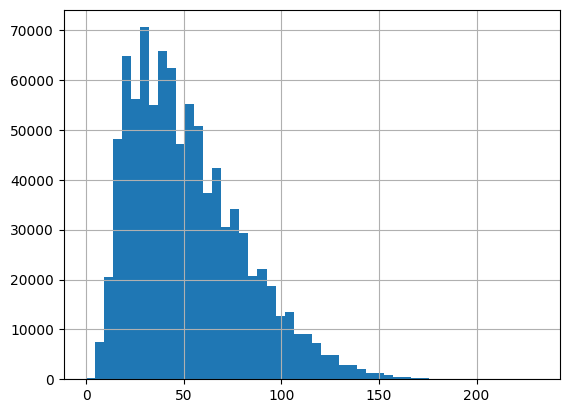

In [42]:

data['sales'].hist(bins=50)

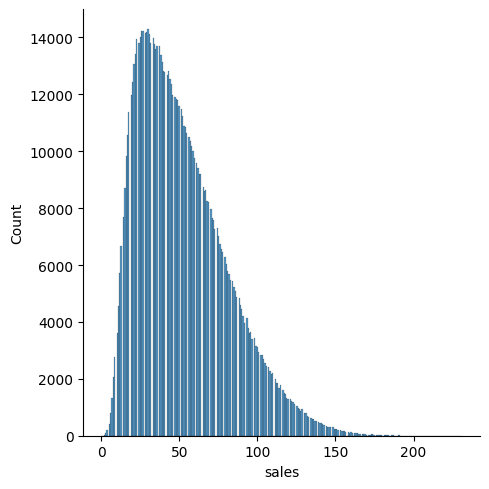

In [43]:
sns.displot(data['sales'])
plt.show()

In [44]:
data['log_sales'] = np.log1p(data['sales'])


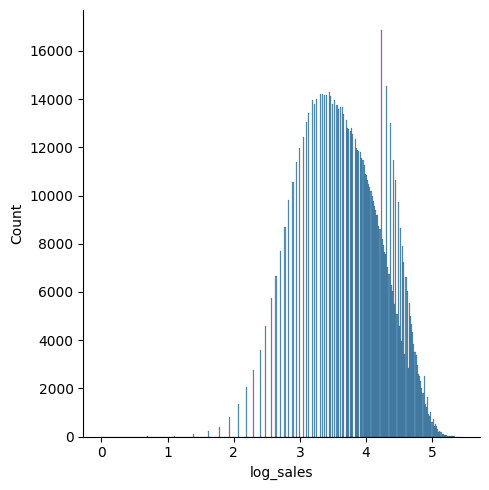

In [45]:
sns.displot(data['log_sales'])
plt.show()

In [46]:
data = data.sort_values(['store', 'item', 'date'])

data['lag_1'] = data.groupby(['store', 'item'])['sales'].shift(1)
data['lag_2'] = data.groupby(['store', 'item'])['sales'].shift(2)
data['lag_3'] = data.groupby(['store', 'item'])['sales'].shift(3)
data['rolling_mean_7'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())


In [47]:
data['day'] = data['date'].dt.day

In [48]:
data.head()

,date,store,item,sales,log_sales,lag_1,lag_2,lag_3,rolling_mean_7,day
0,2013-01-01,1,1,13,2.639057,NaN,NaN,NaN,NaN,1
1,2013-01-02,1,1,11,2.484907,13.0,NaN,NaN,NaN,2
2,2013-01-03,1,1,14,2.708050,11.0,13.0,NaN,NaN,3
3,2013-01-04,1,1,13,2.639057,14.0,11.0,13.0,NaN,4
4,2013-01-05,1,1,10,2.397895,13.0,14.0,11.0,NaN,5


In [49]:
data.dropna(inplace=True)

In [50]:
split_index = int(len(data)*0.8)
train = data.iloc[:split_index]
test = data.iloc[split_index:]

In [51]:
train.head()

,date,store,item,sales,log_sales,lag_1,lag_2,lag_3,rolling_mean_7,day
7,2013-01-08,1,1,9,2.302585,10.0,12.0,10.0,11.857143,8
8,2013-01-09,1,1,12,2.564949,9.0,10.0,12.0,11.285714,9
9,2013-01-10,1,1,9,2.302585,12.0,9.0,10.0,11.428571,10
10,2013-01-11,1,1,9,2.302585,9.0,12.0,9.0,10.714286,11
11,2013-01-12,1,1,7,2.079442,9.0,9.0,12.0,10.142857,12


In [52]:
test.head()

,date,store,item,sales,log_sales,lag_1,lag_2,lag_3,rolling_mean_7,day
14615,2013-01-08,9,1,13,2.639057,7.0,11.0,22.0,14.571429,8
14616,2013-01-09,9,1,9,2.302585,13.0,7.0,11.0,14.857143,9
14617,2013-01-10,9,1,5,1.791759,9.0,13.0,7.0,14.857143,10
14618,2013-01-11,9,1,20,3.044522,5.0,9.0,13.0,12.714286,11
14619,2013-01-12,9,1,11,2.484907,20.0,5.0,9.0,12.428571,12


In [53]:
features = ['lag_1','lag_2','lag_3','day','store','item','rolling_mean_7']
target = 'log_sales'

In [54]:
xgb_1 =xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,max_depth=3)
xgb_1.fit(train[features],train[target])
predic_featres = np.expm1(xgb_1.predict(test[features]))

In [55]:
print(f'MSE: {mean_squared_error(test["sales"],predic_featres)}')
print(f'RMSE: {np.sqrt(test["sales"],predic_featres)}')
print(f'MAE: {mean_absolute_error(test["sales"],predic_featres)}')
print(f'R2: {r2_score(test["sales"],predic_featres)}')
print(f'SMAPE: {smape(test["sales"],predic_featres)}')

MSE: 123.23221588134766
RMSE: 14615     3.605551
14616     3.000000
14617     2.236068
14618     4.472136
14619     3.316625
            ...   
912995    7.937254
912996    7.681146
912997    8.602325
912998    7.874008
912999    9.055386
Name: sales, Length: 181900, dtype: float32
MAE: 49.675537109375
R2: -2.855384588241577
SMAPE: 148.96010570095675


In [56]:
data['monthly'] = data['date'].dt.month
data['yearly'] = data['date'].dt.year
#data['is_weekend'] = data['date'].dt.day_of_week.isin([5,6]).astype(int)
data['dow']  = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)

In [57]:
data.head()

,date,store,item,sales,log_sales,lag_1,lag_2,lag_3,rolling_mean_7,day,monthly,yearly,dow,week_of_year
7,2013-01-08,1,1,9,2.302585,10.0,12.0,10.0,11.857143,8,1,2013,1,2
8,2013-01-09,1,1,12,2.564949,9.0,10.0,12.0,11.285714,9,1,2013,2,2
9,2013-01-10,1,1,9,2.302585,12.0,9.0,10.0,11.428571,10,1,2013,3,2
10,2013-01-11,1,1,9,2.302585,9.0,12.0,9.0,10.714286,11,1,2013,4,2
11,2013-01-12,1,1,7,2.079442,9.0,9.0,12.0,10.142857,12,1,2013,5,2


In [58]:
def create_fourier_features(df,period,order,col=['date']):
  t = np.arange(len(df))
  for k in range(1,order+1):
    df[f'sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
    df[f'cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
  return df

In [59]:
data = data.sort_values('date')
data = create_fourier_features(data,period=7,order=3)

In [60]:
data.head()

,date,store,item,sales,log_sales,lag_1,lag_2,lag_3,rolling_mean_7,day,monthly,yearly,dow,week_of_year,sin_7_1,cos_7_1,sin_7_2,cos_7_2,sin_7_3,cos_7_3
7,2013-01-08,1,1,9,2.302585,10.0,12.0,10.0,11.857143,8,1,2013,1,2,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
728581,2013-01-08,10,40,17,2.890372,16.0,24.0,23.0,19.714286,8,1,2013,1,2,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
529547,2013-01-08,1,30,23,3.178054,16.0,29.0,22.0,23.000000,8,1,2013,1,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
465637,2013-01-08,6,26,22,3.135494,12.0,26.0,28.0,23.000000,8,1,2013,1,2,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
447377,2013-01-08,6,25,31,3.465736,33.0,30.0,32.0,34.285714,8,1,2013,1,2,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


In [61]:
data.columns

Index(['date', 'store', 'item', 'sales', 'log_sales', 'lag_1', 'lag_2',
       'lag_3', 'rolling_mean_7', 'day', 'monthly', 'yearly', 'dow',
       'week_of_year', 'sin_7_1', 'cos_7_1', 'sin_7_2', 'cos_7_2', 'sin_7_3',
       'cos_7_3'],
      dtype='object')

In [62]:
data.shape

(909500, 20)

In [63]:
details = data[['sin_7_3','sin_7_2','sin_7_1','cos_7_3','cos_7_2','cos_7_1']]
print(details)

             sin_7_3       sin_7_2       sin_7_1   cos_7_3   cos_7_2   cos_7_1
7       0.000000e+00  0.000000e+00  0.000000e+00  1.000000  1.000000  1.000000
728581  4.338837e-01  9.749279e-01  7.818315e-01 -0.900969 -0.222521  0.623490
529547 -7.818315e-01 -4.338837e-01  9.749279e-01  0.623490 -0.900969 -0.222521
465637  9.749279e-01 -7.818315e-01  4.338837e-01 -0.222521  0.623490 -0.900969
447377 -9.749279e-01  7.818315e-01 -4.338837e-01 -0.222521  0.623490 -0.900969
...              ...           ...           ...       ...       ...       ...
706661 -4.338837e-01 -9.749279e-01 -7.818315e-01 -0.900969 -0.222521  0.623490
724921 -2.969795e-10 -1.203761e-10 -6.018805e-11  1.000000  1.000000  1.000000
743181  4.338837e-01  9.749279e-01  7.818315e-01 -0.900969 -0.222521  0.623490
505801 -7.818315e-01 -4.338837e-01  9.749279e-01  0.623490 -0.900969 -0.222521
912999  9.749279e-01 -7.818315e-01  4.338837e-01 -0.222521  0.623490 -0.900969

[909500 rows x 6 columns]


In [64]:
split_index = int(len(data)*0.8)
train_x = data.iloc[:split_index]
test_x = data.iloc[split_index:]

In [65]:
scaler = StandardScaler()

In [67]:
non_fourier = ['lag_1','lag_2','lag_3','rolling_mean_7','day','store','item','log_sales','yearly','dow','week_of_year']
for features in non_fourier:
  train_x[non_fourier] = scaler.fit_transform(train_x[non_fourier])
  test_x[non_fourier] = scaler.transform(test_x[non_fourier])



In [68]:
X = train_x.drop(['date','sales','log_sales'],axis=1)
y = train_x['sales']
z = test_x.drop(['date','sales','log_sales'],axis=1)

In [69]:
frame = pd.read_csv('/content/train.csv')
frame.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [70]:
frame['date'] = pd.to_datetime(frame['date'],format='%Y-%m-%d')

In [71]:
frame["Day"] = frame["date"].dt.day
frame["Month"] = frame["date"].dt.month
frame["Years"] = frame["date"].dt.year

In [72]:
frame['log_sales'] = np.log1p(frame['sales'])

In [73]:
frame.head()

,date,store,item,sales,Day,Month,Years,log_sales
0,2013-01-01,1,1,13,1,1,2013,2.639057
1,2013-01-02,1,1,11,2,1,2013,2.484907
2,2013-01-03,1,1,14,3,1,2013,2.708050
3,2013-01-04,1,1,13,4,1,2013,2.639057
4,2013-01-05,1,1,10,5,1,2013,2.397895


In [74]:
X_train = frame.drop(['sales','log_sales','date'],axis=1)
y_train = frame['sales']

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=13)

In [76]:
L = xgb.XGBRegressor()
L.fit(X_train,y_train)
prediction = L.predict(X_test)


In [77]:
print(f'MSE: {mean_squared_error(y_test,prediction)}')
print(f'RMSE: {np.sqrt(y_test,prediction)}')
print(f'MAE: {mean_absolute_error(y_test,prediction)}')
print(f'R2: {r2_score(y_test,prediction)}')
#print(f'SMAPE: {smape(y_test,prediction)}')

MSE: 99.98081970214844
RMSE: 304611    4.123106
175704    6.324555
22890     8.888194
89001     4.582576
159910    9.055386
            ...   
625854    9.899495
826285    9.273619
867570    6.403124
854462    4.472136
559747    5.916080
Name: sales, Length: 182600, dtype: float32
MAE: 45.27016067504883
R2: -2.3429017066955566
